In [23]:
from statsbombpy import sb
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from data_pre import get_df, data_prep, one_hot, evaluation
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
 #Import Data from statsbombpy
competitions = sb.competitions()
fifa_2022 = sb.matches(competition_id=43, season_id=106)

#Grouped events
events_fifa = sb.competition_events(
    country="International",
    division='FIFA World Cup',
    season="2022",
    gender="male"
)


In [3]:
risk_df = get_df(events_fifa)

In [5]:
risk_df = data_prep(risk_df)
risk_df = one_hot(risk_df)

Number of risky passes: 10,952
Number of not risky passes: 53,428


In [6]:
risk_df = risk_df.drop(columns=['pass_body_part_Other' ])

In [7]:
# Splitting the data into features (X) and target variable (y)
X = risk_df.iloc[:, 1:]
y = risk_df.iloc[:, 0]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Splitting the data into validation test set
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Random Forests

In [17]:
# Random Forest Classifier without tuning
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train, y_train)
random_forest_predictions = random_forest_classifier.predict(X_train_val)
random_forest_accuracy_no_tuning = accuracy_score(y_train_val, random_forest_predictions)

print("Random Forest Classifier Accuracy:", random_forest_accuracy_no_tuning*100)

Random Forest Classifier Accuracy: 86.06710158434296


In [26]:
# oob_score
random_forest_classifier = RandomForestClassifier(random_state=42,
                                                oob_score = True,
                                                min_samples_leaf = 50,
                                                max_features= 10,
                                                n_estimators = 1000)
random_forest_classifier = random_forest_classifier.fit(X_train, y_train)

In [30]:
accuracy_rf = []
max_feature = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
node_size = [1, 2, 5, 10, 20, 35, 50, 75]

max_accuracy = random_forest_accuracy_no_tuning*100

for i in range(len(max_feature)):
    for j in range(len(node_size)):
        random_forest_classifier = RandomForestClassifier(random_state=42,
                                                        oob_score = True,
                                                        min_samples_leaf = node_size[j],
                                                        max_features= max_feature[i],
                                                        n_estimators = 1000,
                                                        )
        random_forest_classifier = random_forest_classifier.fit(X_train_val, y_train_val)

        # Evaluate the model performance
        rf_accuracy = random_forest_classifier.oob_score_*100

        if rf_accuracy > max_accuracy:
            max_accuracy = rf_accuracy
            optimal_feature = max_feature[i]
            optimal_node = node_size[j]

        accuracy_rf.append(rf_accuracy)

In [53]:
print("Optimal OOB score: " + str(max_accuracy), "\n", "Optimal feature: " + str(optimal_feature), "\n", "Optimal node: " + str(optimal_node))

Optimal OOB score: 87.7152354325685 
 Optimal feature: 10 
 Optimal node: 50


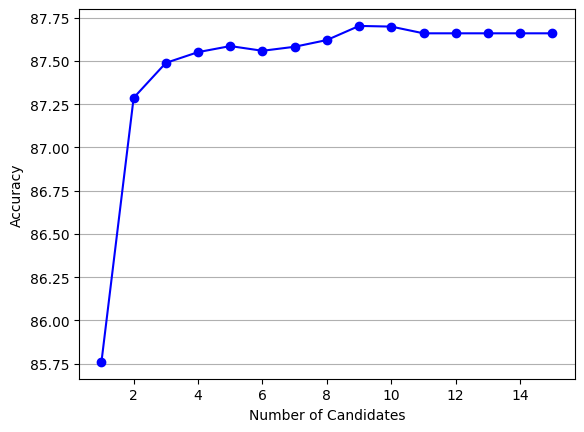

In [41]:
max_feature = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy_rf = []

for i in range(len(max_feature)):
    random_forest_classifier = RandomForestClassifier(random_state=42,
                                                    oob_score = True,
                                                    min_samples_leaf = 50,
                                                    max_features= max_feature[i],
                                                    n_estimators = 1000,
                                                    )
    random_forest_classifier = random_forest_classifier.fit(X_train, y_train)

    rf_predictions = random_forest_classifier.predict(X_test)

    # Evaluate the model performance
    rf_accuracy = accuracy_score(y_test, rf_predictions)*100

    accuracy_rf.append(rf_accuracy)

# Plot the line graph
plt.plot(max_feature, accuracy_rf, color='blue', marker='o')
plt.xlabel('Number of Candidates')
plt.ylabel('Accuracy')
plt.grid(axis='y')  # Remove vertical grid lines

#plt.savefig(f'rf_number_candidates.png', bbox_inches='tight')

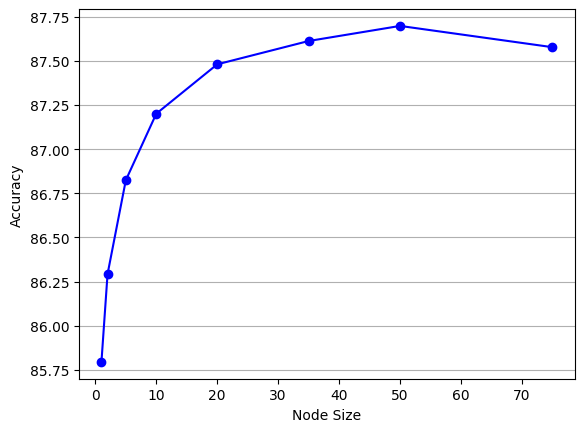

In [43]:
node_size = [1, 2, 5, 10, 20, 35, 50, 75]
accuracy_rf = []

for i in range(len(node_size)):
    random_forest_classifier = RandomForestClassifier(random_state=42,
                                                    oob_score = True,
                                                    min_samples_leaf = node_size[i],
                                                    max_features= 10,
                                                    n_estimators = 1000,
                                                    )
    random_forest_classifier = random_forest_classifier.fit(X_train, y_train)

    rf_predictions = random_forest_classifier.predict(X_test)

    # Evaluate the model performance
    rf_accuracy = accuracy_score(y_test, rf_predictions)*100

    accuracy_rf.append(rf_accuracy)

# Plot the line graph
plt.plot(node_size, accuracy_rf, color='blue', marker='o')
plt.xlabel('Node Size')
plt.ylabel('Accuracy')
plt.grid(axis='y')  # Remove vertical grid lines

#plt.savefig(f'rf_number_candidates.png', bbox_inches='tight')

Evaluation Measures

In [44]:
eval_rf = evaluation(y_test, rf_predictions)

Validation Test

In [45]:
# Merge 60% x_train with 20% x_train and similar for Y
x_train_val_final = pd.concat([X_train, X_train_val], ignore_index=True)

y_train_val_final = pd.concat([y_train, y_train_val], ignore_index=True)

In [48]:
random_forest_classifier = RandomForestClassifier(random_state=42,
                                                max_features= 10,
                                                min_samples_leaf = 50,
                                                n_estimators = 1000)

random_forest_classifier = random_forest_classifier.fit(x_train_val_final, y_train_val_final)


# Make predictions on the test set
rf_predictions_val = random_forest_classifier.predict(X_test_val)

# Evaluate the model performance
rf_accuracy_val = accuracy_score(y_test_val, rf_predictions_val)
print("Random Forest Classifier Accuracy in Validation Test:", rf_accuracy_val*100)

Random Forest Classifier Accuracy in Validation Test: 87.73687480584033


In [49]:
eval_rf = evaluation(y_test_val, rf_predictions_val)

Importance scores - Permutation Importance

In [50]:
#Random Forests
# Access variable importance scores
importance_scores = random_forest_classifier.feature_importances_

# Display variable importance scores
for i, score in enumerate(importance_scores):
    print(f"Feature {i + 1}: Importance Score = {score:.4f}")

Feature 1: Importance Score = 0.2159
Feature 2: Importance Score = 0.1526
Feature 3: Importance Score = 0.5454
Feature 4: Importance Score = 0.0598
Feature 5: Importance Score = 0.0181
Feature 6: Importance Score = 0.0000
Feature 7: Importance Score = 0.0015
Feature 8: Importance Score = 0.0000
Feature 9: Importance Score = 0.0041
Feature 10: Importance Score = 0.0000
Feature 11: Importance Score = 0.0026


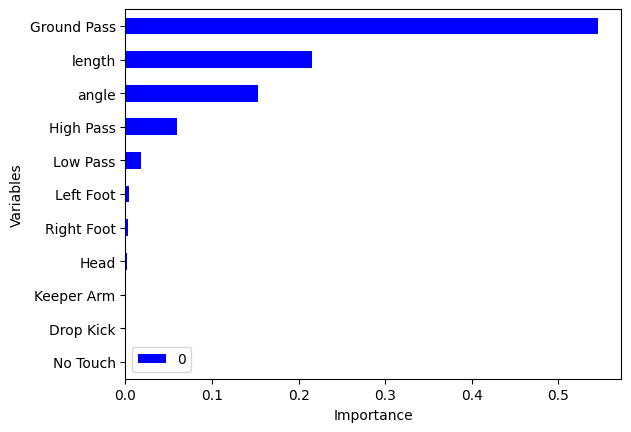

In [51]:
global_importances = pd.Series(random_forest_classifier.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)

# Remove specified prefixes from column names
global_importances = global_importances.to_frame()
global_importances.index = global_importances.index.str.replace('pass_body_part_', '').str.replace('pass_height_', '').str.replace('pass_', '')

global_importances.plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Variables")

plt.savefig(f'RF_importance', bbox_inches='tight')